In [3]:
try:
    import pint
except ImportError:
    !pip install pint

In [4]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

Downloaded modsim.py


In [5]:
from modsim import *

In [6]:
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/data/World_population_estimates.html')

Downloaded World_population_estimates.html


In [7]:
from pandas import read_html

filename = 'World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison',
                  'hyde', 'tanton', 'biraben', 'mj',
                  'thomlinson', 'durand', 'clark']

In [8]:
un = table2.un / 1e9
census = table2.census / 1e9

t_0 = census.index[0]
t_end = census.index[-1]
elapsed_time = t_end - t_0

p_0 = census[t_0]
p_end = census[t_end]

total_growth = p_end - p_0
annual_growth = total_growth / elapsed_time

In [9]:
system = System(t_0=t_0,
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

In [10]:
show(system)

,value
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
annual_growth,0.072248


In [11]:
def run_simulation1(system):
    results = TimeSeries()
    results[system.t_0] = system.p_0

    for t in range(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth

    return results

In [12]:
results1 = run_simulation1(system)

In [13]:
def plot_estimates():
    census.plot(style=':', label='US Census')
    un.plot(style='--', label='UN DESA')
    decorate(xlabel='Year',
             ylabel='World population (billion)')

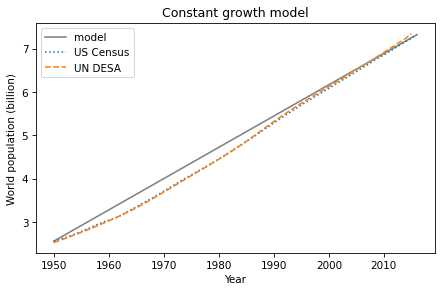

In [14]:
results1.plot(label='model', color='gray')
plot_estimates()
decorate(title='Constant growth model')

In [15]:
def run_simulation2(system):
    results = TimeSeries()
    results[system.t_0] = system.p_0

    for t in range(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths

    return results

In [16]:
system.death_rate = 7.7 / 1000
system.birth_rate = 25 / 1000

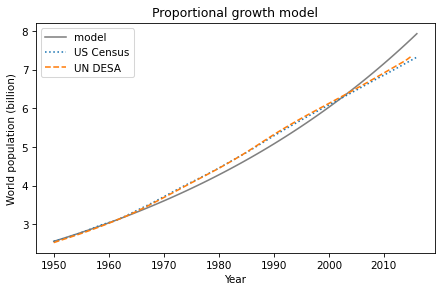

In [17]:
results2 = run_simulation2(system)
results2.plot(label='model', color='gray')
plot_estimates()
decorate(title='Proportional growth model')

In [18]:
def growth_func1(t, pop, system):
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return births - deaths

In [19]:
def run_simulation(system, growth_func):
    results = TimeSeries()
    results[system.t_0] = system.p_0

    for t in range(system.t_0, system.t_end):
        growth = growth_func(t, results[t], system)
        results[t+1] = results[t] + growth

    return results

In [20]:
results = run_simulation(system, growth_func1)

In [21]:
system.alpha = system.birth_rate - system.death_rate

In [22]:
def growth_func2(t, pop, system):
    return system.alpha * pop

In [23]:
results = run_simulation(system, growth_func2)

In [24]:
def growth_func3(t, pop, system):
    """Compute the population next year.

    t: current year
    pop: current population
    system: system object containing parameters of the model

    returns: population next year
    """
    if t < 1980:
        return system.alpha1 * pop
    else:
        return system.alpha2 * pop

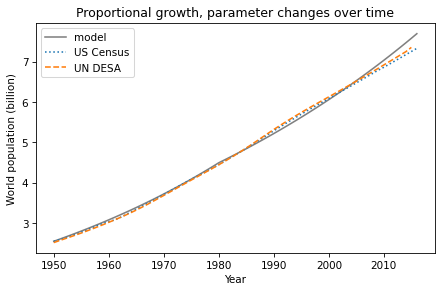

In [26]:
system.alpha1 = 19 / 1000
system.alpha2 = 15 / 1000

results3 = run_simulation(system, growth_func3)
results3.plot(label='model', color='gray')
plot_estimates()
decorate(title='Proportional growth, parameter changes over time')